In [1]:
import pyvo as vo
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.utils.data import download_file
from astropy.io import fits
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
import pandas as pd
from scipy.spatial import KDTree
import json

from scipy.optimize import curve_fit
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std, sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

In [2]:
%matplotlib inline

# Going to try debugging this one now

In [ ]:

   #grab the x-ray sources for this galaxy
#import huge csv and grab the name and ra and dec needed for each source.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec', 'Gname_Modified','Gname_Homogenized']
g_huge = huge[columns]
g_huge[0:100]

#locate through merging
df1 = targetgals
df2 = g_huge

merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns = ['RA','Dec','Gname_Homogenized']
Xray_sources = merged_data[columns]
Xray_sources

# just want NGC 7793s sources
sources_7793 = Xray_sources.loc[Xray_sources['Gname_Homogenized'] == 'NGC 7793']
#sources_7793
#define the X-ray sources of NGC 7793
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask

# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6,'w4':12.98 }
#empty data frame to append values of flux to
rows=[]

In [ ]:
# Query the image catalog in the WISE database
#define coordinates	make it possible to run a list over this with all of the ra and decs
ra= 359.45700000000016
dec= -32.592000000000013

pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
#print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6,'w4':12.98 }

M0instr =  12.98 # found the relative instrumental zero point magnitude in this specific band (W4)
flx_conv_fact =  8.363 # the Zero Magnitude Flux Density conversion factor in this band

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)
#extract a cutout for plotting and KDTree
wcs = WCS(image1[0].header)
#cuting out the image of the galaxy apart from the rest of the background.
cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
wcs = cutout.wcs

#####   constants in every image:

#plot the sources with circles
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra, dec)
positions = np.array(list(zip(positions[0], positions[1])))

#define the distance threshold for the KDTree grouping (in pixels)
distance_threshold = 5

#build the KDTree for efficient grouping
tree = KDTree(positions)

#query the KDTree to find points within the defined radius of dist threshold and group them together
groups = tree.query_ball_tree(tree, r=distance_threshold)
print(groups)
# consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
unique_groups = []
seen = set()
for group in groups:
    group = tuple(sorted(group))
    if group not in seen:
        seen.add(group)
        unique_groups.append(group)
print(unique_groups)
# for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
#represents the consolidated postion of potentially multiple detections of one source.
grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
print(grouped_positions)

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
#empty data frame to append values of flux to
rows=[]


# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask



#####  End of constants










##running the for loop over every image and doing aperture photometry on each one
#currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        #now inputting the aperture photometry part
        # check for overlap and perform aperture photometry
        for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
            overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
            non_overlapping_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x,y), r)

            for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                if i != j: # ensures that a source is not compared to itself! wow
                    distance = dist((x, y) , (x2, y2)) 
                    if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                        overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                        if overlap_percent > .5:
                            overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                            break
                        else: 
                            overlap_mask = create_circular_mask(image_data.shape[0], image_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                            # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                            # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                        
            if overlap:
                #flag the sources that overlap
                rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                            'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
            else: #perform all the aperture photometry stuff
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                # also now apply the masked data
                masked_data = image_data * non_overlapping_mask
                target_photo_table = aperture_photometry(image_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
                target_counts = target_photo_table['aperture_sum'][0]

                if target_counts<= 0: # 
                    target_flux # avoid taking the log of zero or negative value
                else:
                        #counts to flux
                    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                    #calculate area of annulus
                target_area = target_aperture.area



                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(image_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
            
                if annulus_counts <= 0:
                    annulus_flux = 0  # Avoid taking log of zero or negative value
                else:
                    #counts to flux
                    Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

                #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
            
                #   Append the result as a dictionary to the list named 'rows'
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': image_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
            #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
            #filter only valid sources to conduct the overlapping photometry again. 
        # so that sources with an acceptable amount of overlap have their overlapping counts subtracted from the nonoverlapping counts.
        #valid_sources = display_data[display_data['Flag'] == 'Valid']

        for i, valid_row in display_data[display_data['Flag'] == 'Valid'].iterrows():
            x, y, r = valid_row['X'], valid_row['Y'], valid_row['Radius']
            target_aperture = CircularAperture((x, y), r)
            target_photo_table = aperture_photometry(image_data, target_aperture)
            target_counts = target_photo_table['aperture_sum'][0]
            
            if target_counts <= 0:
                target_flux = 0
            else:
                Mcal_trgt = M0instr - 2.5 * (np.log10(target_counts))
                target_flux = flx_conv_fact * 10**(Mcal_trgt / -2.5)
                target_area = target_aperture.area

            non_overlapping_counts = target_counts

            for j, valid_row2 in display_data[display_data['Flag'] == 'Valid'].iterrows():
                if i != j:
                    x2, y2, r2 = valid_row2['X'], valid_row2['Y'], valid_row2['Radius']
                    distance = dist((x, y), (x2, y2))
                    if distance < r + r2:
                        overlap_percent = (r + r2 - distance) / (r + r2)
                        if overlap_percent > .01: # i think i will have to fiddle around with this
                            overlap_aperture = CircularAperture((x2, y2), r2)
                            overlap_photo_table = aperture_photometry(image_data, overlap_aperture)
                            overlap_counts = overlap_photo_table['aperture_sum'][0]
                            #Subtract overlapping data from non overlapping and assign the data to the variable of non_overlapping_counts
                            non_overlapping_counts -= overlap_counts
                            

            if non_overlapping_counts <= 0: # if counts are 0 or negative, dont do flux conversion cuz it wont work. assigns the flux to be zero
                net_flux = 0
            else:
                Mcal_trgt = M0instr - 2.5 * (np.log10(non_overlapping_counts))
                net_flux = flx_conv_fact * 10**(Mcal_trgt / -2.5) - tot_bg

            # for each location of the overlapping source in the pandas dataframe table, assign whether it is still valid or not.
            display_data.loc[i, 'Net Flux (Jy)'] = net_flux
            display_data.loc[i, 'Flag'] = 'Valid' if net_flux > 0 else 'Low Flux'

     
        
     ## Trying to plot the images now
     #extract a cutout and plot it
        wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (400,400), wcs=wcs)
        wcs = cutout.wcs
    
        #plotting the image
        fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
        norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
        for row in display_data.itertuples():
            if row.Flag == 'Valid':
                target_aperture = CircularAperture((row.X, row.Y), row.Radius)
                annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
                target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
                annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
        ax.imshow(cutout.data, cmap= 'gray', norm=norm)

        ax.set_xlabel('Right Ascension')
        ax.set_ylabel('Declination')
        plt.title(f'Band {band_labels[band_id]}')
        plt.show()
    





#rows.append({'band_id': {band_labels[band_id]},
    
display_data = pd.DataFrame(rows)
display_data

#visualizing the apertures

#for row in display_data.itertuples():
    #if row.Flag == 'Valid':
       # target_aperture = CircularAperture((row.X, row.Y), row.Radius)
       # annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
       # target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
       # annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)

####if you want to see all of them use the code below:
#for ((x, y), r, annulus_inner, annulus_outer) in ROI:
    #target_apertureplt = CircularAperture((x,y),r)
   # annulus_apertureplt = CircularAnnulus((x, y), annulus_inner, annulus_outer)
   # target_apertureplt.plot(color='red', lw = 1.5)
   # annulus_apertureplt.plot(color='red', lw = 1.5)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(color='white', ls='dotted')
plt.show()



display(display_data.loc[display_data['Flag']== 'Valid'])
pd.set_option("display.max_rows", None)





# Just one band

In [ ]:
#define coordinates	
ra= 359.45700000000016
dec= -32.592000000000013
pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#im_table
im_table.to_table().colnames
#for i in range(len(im_table)):
   # print(im_table[i])

In [ ]:
for i in range(len(im_table)):
    if im_table[i]['sia_bp_id']:

        print(im_table[i].getdataurl())

In [ ]:
data_url = im_table[0].getdataurl()
#Download the image and open it in Astropy
fname = download_file(data_url, cache=True)
image1= fits.open(fname)
image_data= image1[0].data
print(data_url)

In [ ]:
#grab the x-ray sources for this galaxy
#import huge csv and grab the name and ra and dec needed for each source.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec', 'Gname_Modified','Gname_Homogenized']
g_huge = huge[columns]
g_huge[0:100]

#locate through merging
df1 = targetgals
df2 = g_huge

merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns = ['RA','Dec','Gname_Homogenized']
Xray_sources = merged_data[columns]
Xray_sources

# just want NGC 7793s sources
sources_7793 = Xray_sources.loc[Xray_sources['Gname_Homogenized'] == 'NGC 7793']
sources_7793


In [ ]:
#define the X-ray sources of NGC 7793
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values


In [ ]:
#extract a cutout for plotting and KDTree
wcs = WCS(image1[0].header)
#cuting out the image of the galaxy apart from the rest of the background.
cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
print(image_data.shape)
print(cutout.data.shape)
# THIS IS WHERE THE DISCREPANCY IS HAPPENING.
# When i make the image shape the same, the positions of the sources are almost identical to the 
# image downloaded code.
wcs = cutout.wcs
cutout_data = cutout.data

In [ ]:
#define the KDTree
# convert Ra and dec values to pixel coordinates
positions = wcs.world_to_pixel_values(ra, dec)
positions = np.array(list(zip(positions[0], positions[1])))

#define the distance threshold for the KDTree grouping (in pixels)
distance_threshold = 10

#build the KDTree for efficient grouping
tree = KDTree(positions)

#query the KDTree to find points within the defined radius of dist threshold and group them together
groups = tree.query_ball_tree(tree, r=distance_threshold)
print(groups)
# consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
unique_groups = []
seen = set()
for group in groups:
    group = tuple(sorted(group))
    if group not in seen:
        seen.add(group)
        unique_groups.append(group)
print(unique_groups)
# for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
#represents the consolidated postion of potentially multiple detections of one source.
grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
print(grouped_positions)
# a problem could be with grouped postions maybe?
# here is where the code between downloading the image and using the URL differs!
#  the position of sources is slightly altered for some reason.

In [ ]:

#define the Region(s) Of Interest (center x, center y, radius)
ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
#empty data frame to append values of flux to
rows=[]


# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask

# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6,'w4':12.98 }

M0instr =  12.98 # found the relative instrumental zero point magnitude in this specific band (W4)
flx_conv_fact =  8.363 # the Zero Magnitude Flux Density conversion factor in this band
cutout_data.shape
grouped_positions


In [ ]:

# check for overlap and perform aperture photometry
for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
    overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
    non_overlapping_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x,y), r)

    for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
        if i != j: # ensures that a source is not compared to itself! wow
            distance = dist((x, y) , (x2, y2)) 
            if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                if overlap_percent > .5:
                    overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                    break
                else: 
                    overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                    non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                    # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                    # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                
    if overlap:
        #flag the sources that overlap
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                      'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
    else: #perform all the aperture photometry stuff
        # For the Target objects in the little aperture circle define their target apertures
        target_aperture = CircularAperture((x,y),r,)
    
        #perform aperture photometry on target
        # also now apply the masked data
        masked_data = cutout_data * non_overlapping_mask
        target_photo_table = aperture_photometry(cutout_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
        target_counts = target_photo_table['aperture_sum'][0]

        if target_counts<= 0: # 
            target_flux # avoid taking the log of zero or negative value
        else:
                #counts to flux
            Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
            target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
            #calculate area of annulus
        target_area = target_aperture.area



        # For the Background Annuli of outside of the Target
        #define the background annulus for the target
        annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

        #perform aperture photometry on annuli
        annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
        annulus_counts = annulus_photo_table['aperture_sum'][0]
    
        if annulus_counts <= 0:
            annulus_flux = 0  # Avoid taking log of zero or negative value
        else:
            #counts to flux
            Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
            annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

        #calculate area of annulus
        annulus_area = annulus_aperture.area

        # do the calculations for including a Background aperture
    
        #Calculating the net flux:
        #calculate the mean background per pixel
        bg_perpixel = annulus_flux/annulus_area

        #calculate the total background in the target aperture
        tot_bg = bg_perpixel * target_area

        #Subtract background from the target flux
        net_flx = target_flux - tot_bg
    
        #   Append the result as a dictionary to the list named 'rows'
        rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                 'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                   'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                     'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                       'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
    

#append the rows to the empty dataframe    
display_data = pd.DataFrame(rows)
display_data

valid_sources = display_data[display_data['Flag'] == 'Valid']

for i, valid_row in valid_sources.iterrows():
    x, y, r = valid_row['X'], valid_row['Y'], valid_row['Radius']
    target_aperture = CircularAperture((x, y), r)
    target_photo_table = aperture_photometry(cutout_data, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    if target_counts <= 0:
        target_flux = 0
    else:
        Mcal_trgt = M0instr - 2.5 * (np.log10(target_counts))
        target_flux = flx_conv_fact * 10**(Mcal_trgt / -2.5)
        target_area = target_aperture.area

    non_overlapping_counts = target_counts

    for j, valid_row2 in valid_sources.iterrows():
        if i != j:
            x2, y2, r2 = valid_row2['X'], valid_row2['Y'], valid_row2['Radius']
            distance = dist((x, y), (x2, y2))
            if distance < r + r2:
                overlap_percent = (r + r2 - distance) / (r + r2)
                if overlap_percent > .01: # i think i will have to fiddle around with this
                    overlap_aperture = CircularAperture((x2, y2), r2)
                    overlap_photo_table = aperture_photometry(cutout_data, overlap_aperture)
                    overlap_counts = overlap_photo_table['aperture_sum'][0]
                    #Subtract overlapping data from non overlapping and assign the data to the variable of non_overlapping_counts
                    non_overlapping_counts -= overlap_counts
                    

    if non_overlapping_counts <= 0: # if counts are 0 or negative, dont do flux conversion cuz it wont work. assigns the flux to be zero
        net_flux = 0
    else:
        Mcal_trgt = M0instr - 2.5 * (np.log10(non_overlapping_counts))
        net_flux = flx_conv_fact * 10**(Mcal_trgt / -2.5) - tot_bg

    # for each location of the overlapping source in the pandas dataframe table, assign whether it is still valid or not.
    display_data.loc[i, 'Net Flux (Jy)'] = net_flux
    display_data.loc[i, 'Flag'] = 'Valid' if net_flux > 0 else 'Low Flux'



#visualizing the apertures that are postive and dont overlap to a detrimental degree. if you want to see all of them take out the (== 'Valid') part of the viz code
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
for row in display_data.itertuples():
    if row.Flag == 'Valid':
        target_aperture = CircularAperture((row.X, row.Y), row.Radius)
        annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
        target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
        annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
ax.imshow(cutout.data, cmap= 'gray', norm=norm)

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
#plt.title(f'Band {band_labels[band_id]}')
plt.show()

display_data.loc[display_data['Flag']== 'Valid']



## dont think i need this 

In [ ]:


#filter only valid sources to conduct the overlapping photometry again. 
# so that sources with an acceptable amount of overlap have their overlapping counts subtracted from the nonoverlapping counts.
valid_sources = display_data[display_data['Flag'] == 'Valid']

for i, valid_row in valid_sources.iterrows():
    x, y, r = valid_row['X'], valid_row['Y'], valid_row['Radius']
    target_aperture = CircularAperture((x, y), r)
    target_photo_table = aperture_photometry(cutout_data, target_aperture)
    target_counts = target_photo_table['aperture_sum'][0]
    
    if target_counts <= 0:
        target_flux = 0
    else:
        Mcal_trgt = M0instr - 2.5 * (np.log10(target_counts))
        target_flux = flx_conv_fact * 10**(Mcal_trgt / -2.5)
        target_area = target_aperture.area

    non_overlapping_counts = target_counts

    for j, valid_row2 in valid_sources.iterrows():
        if i != j:
            x2, y2, r2 = valid_row2['X'], valid_row2['Y'], valid_row2['Radius']
            distance = dist((x, y), (x2, y2))
            if distance < r + r2:
                overlap_percent = (r + r2 - distance) / (r + r2)
                if overlap_percent > .01: # i think i will have to fiddle around with this
                    overlap_aperture = CircularAperture((x2, y2), r2)
                    overlap_photo_table = aperture_photometry(cutout_data, overlap_aperture)
                    overlap_counts = overlap_photo_table['aperture_sum'][0]
                    #Subtract overlapping data from non overlapping and assign the data to the variable of non_overlapping_counts
                    non_overlapping_counts -= overlap_counts
                    

    if non_overlapping_counts <= 0: # if counts are 0 or negative, dont do flux conversion cuz it wont work. assigns the flux to be zero
        net_flux = 0
    else:
        Mcal_trgt = M0instr - 2.5 * (np.log10(non_overlapping_counts))
        net_flux = flx_conv_fact * 10**(Mcal_trgt / -2.5) - tot_bg

    # for each location of the overlapping source in the pandas dataframe table, assign whether it is still valid or not.
    display_data.loc[i, 'Net Flux (Jy)'] = net_flux
    display_data.loc[i, 'Flag'] = 'Valid' if net_flux > 0 else 'Low Flux'


#visualizing the apertures that are postive and dont overlap to a detrimental degree. if you want to see all of them take out the (== 'Valid') part of the viz code
fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
for row in display_data.itertuples():
    if row.Flag == 'Valid':
        target_aperture = CircularAperture((row.X, row.Y), row.Radius)
        annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
        target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
        annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
ax.imshow(cutout.data, cmap= 'gray', norm=norm)

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
#plt.title(f'Band {band_labels[band_id]}')
plt.show()

display_data.loc[display_data['Flag']== 'Valid']
#display_data

# the new code for when i want to apply it to all wavelengths :

remember to include the code for different flux conversions for each band!!

In [ ]:
#define coordinates	
ra= 359.45700000000016
dec= -32.592000000000013
pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#im_table
im_table.to_table().colnames
for i in range(len(im_table)):
    print(im_table[i])


   #grab the x-ray sources for this galaxy
#import huge csv and grab the name and ra and dec needed for each source.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec', 'Gname_Modified','Gname_Homogenized']
g_huge = huge[columns]
g_huge[0:100]

#locate through merging
df1 = targetgals
df2 = g_huge

merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns = ['RA','Dec','Gname_Homogenized']
Xray_sources = merged_data[columns]
Xray_sources

# just want NGC 7793s sources
sources_7793 = Xray_sources.loc[Xray_sources['Gname_Homogenized'] == 'NGC 7793']
#sources_7793
#define the X-ray sources of NGC 7793
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask

# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6,'w4':12.98 }


In [ ]:
#DELETE THIS WHEN YOU HAVE PUT IN THE CONVERSION Code
M0instr =  12.98 # found the relative instrumental zero point magnitude in this specific band (W4)
flx_conv_fact =  8.363 # the Zero Magnitude Flux Density conversion factor in this band

## dont use this

In [ ]:
cutout_alldata = []
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
       # print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)
        
        wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
        wcs = cutout.wcs
        cutout_data = cutout.data # maybe this needs to be assigned as a dictionary for each of them.
        cutout_alldata.append({ 'Band': {band_labels[band_id]}, 'CutoutData' : cutout_data, 'WCS': wcs})
cutout_alldata = pd.DataFrame(cutout_alldata)
cutout_alldata['ROI'] = np.nan
display(cutout_alldata)

#cutout_alldata = pd.DataFrame(columns=['Band', 'CutoutData', 'WCS'])  # Initialize with columns
#for i in [0, 3, 2, 1]:  # Reverse order index
  #  band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
   # if band_id in band_labels:
   #    # print(f'Band {band_labels[band_id]}: ')
    #    data_url = im_table[i].getdataurl()
   #     #Download the image and open it in Astropy
   #     fname = download_file(data_url, cache=True)
   #     image1= fits.open(fname)
    #    image_data= image1[0].data
        #print(data)
        
     #   wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
     #   cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
      #  wcs = cutout.wcs
      #  cutout_data = cutout.data # maybe this needs to be assigned as a dictionary for each of them.
      #  cutout_alldata.loc[len(cutout_alldata)] = [band_id, cutout_data, wcs]
        #cutout_alldata._append({ 'Band': {band_labels[band_id]}, 'CutoutData' : cutout_data, 'WCS': wcs}, ignore_index= True)

display(cutout_alldata)

for idx, row in cutout_alldata.iterrows():
    wcs = row.WCS
    positions = wcs.world_to_pixel_values(ra, dec)
    positions = np.array(list(zip(positions[0], positions[1])))

    #define the distance threshold for the KDTree grouping (in pixels)
    distance_threshold = 11

    #build the KDTree for efficient grouping
    tree = KDTree(positions)

    #query the KDTree to find points within the defined radius of dist threshold and group them together
    groups = tree.query_ball_tree(tree, r=distance_threshold)
    print(groups)
    # consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
    unique_groups = []
    seen = set()
    for group in groups:
        group = tuple(sorted(group))
        if group not in seen:
            seen.add(group)
            unique_groups.append(group)
    print(unique_groups)
    # for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
    #represents the consolidated postion of potentially multiple detections of one source.
    grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
    print(grouped_positions)

    #define the Region(s) Of Interest (center x, center y, radius)
    ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
    #empty data frame to append values of flux to
    roi_str = json.dumps(ROI) # to revert back : roi_list = json.loads(cutout_alldata.at[idx, 'ROI'])
    cutout_alldata.at[idx, 'ROI'] = roi_str
display(cutout_alldata)

for idx, row in cutout_alldata.iterrows(): 
    roi_list = json.loads(row['ROI'])
    band_id = row['Band']
    cutout_data = row['CutoutData']
    #now inputting the aperture photometry part
    # check for overlap and perform aperture photometry
    for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(roi_list):
        overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
        non_overlapping_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x,y), r)

        for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(roi_list): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
            if i != j: # ensures that a source is not compared to itself! wow
                distance = dist((x, y) , (x2, y2)) 
                if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                    overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                    if overlap_percent > .5:
                        overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                        break
                    else: 
                        overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                        non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                        # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                        # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                    
        if overlap:
            #flag the sources that overlap
            rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
        else: #perform all the aperture photometry stuff
            # For the Target objects in the little aperture circle define their target apertures
            target_aperture = CircularAperture((x,y),r,)
        
            #perform aperture photometry on target
            # also now apply the masked data
            masked_data = cutout_data * non_overlapping_mask
            target_photo_table = aperture_photometry(cutout_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
            target_counts = target_photo_table['aperture_sum'][0]

            if target_counts<= 0: # 
                target_flux # avoid taking the log of zero or negative value
            else:
                    #counts to flux
                Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                #calculate area of annulus
            target_area = target_aperture.area



            # For the Background Annuli of outside of the Target
            #define the background annulus for the target
            annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

            #perform aperture photometry on annuli
            annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
            annulus_counts = annulus_photo_table['aperture_sum'][0]
        
            if annulus_counts <= 0:
                annulus_flux = 0  # Avoid taking log of zero or negative value
            else:
                #counts to flux
                Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

            #calculate area of annulus
            annulus_area = annulus_aperture.area

            # do the calculations for including a Background aperture
        
            #Calculating the net flux:
            #calculate the mean background per pixel
            bg_perpixel = annulus_flux/annulus_area

            #calculate the total background in the target aperture
            tot_bg = bg_perpixel * target_area

            #Subtract background from the target flux
            net_flx = target_flux - tot_bg
        
            #   Append the result as a dictionary to the list named 'rows'
            rows.append({ 'band_id': band_id,'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                    'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                    'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                        'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                        'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
        #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
    
display_data = pd.DataFrame(rows)
display(display_data)

fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
for row in display_data.itertuples():
    if row.Flag == 'Valid':
        target_aperture = CircularAperture((row.X, row.Y), row.Radius)
        annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
        target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
        annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
ax.imshow(cutout.data, cmap= 'gray', norm=norm)

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
#plt.title(f'Band {band_labels[band_id]}')
plt.show()


## maybe

In [ ]:

##running the for loop over every image and doing aperture photometry on each one
#currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        print(data_url)
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)
        
        wcs = WCS(image1[0].header)
        #cutting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
        wcs = cutout.wcs
        cutout_data = cutout.data

        positions = wcs.world_to_pixel_values(ra, dec)
        positions = np.array(list(zip(positions[0], positions[1])))

        #define the distance threshold for the KDTree grouping (in pixels)
        distance_threshold = 10

        #build the KDTree for efficient grouping
        tree = KDTree(positions)

        #query the KDTree to find points within the defined radius of dist threshold and group them together
        groups = tree.query_ball_tree(tree, r=distance_threshold)
        print(groups)
        # consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
        unique_groups = []
        seen = set()
        for group in groups:
            group = tuple(sorted(group))
            if group not in seen:
                seen.add(group)
                unique_groups.append(group)
        print(unique_groups)
        # for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
        #represents the consolidated postion of potentially multiple detections of one source.
        grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
        print(grouped_positions)

        #define the Region(s) Of Interest (center x, center y, radius)
        ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
        #empty data frame to append values of flux to


        #now inputting the aperture photometry part
        # check for overlap and perform aperture photometry
        for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
            overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
            non_overlapping_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x,y), r)

            for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                if i != j: # ensures that a source is not compared to itself! wow
                    distance = dist((x, y) , (x2, y2)) 
                    if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                        overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                        if overlap_percent > .5:
                            overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                            break
                        else: 
                            overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                            # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                            # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                        
            if overlap:
                #flag the sources that overlap
                rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                            'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
            else: #perform all the aperture photometry stuff
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                # also now apply the masked data
                masked_data = cutout_data * non_overlapping_mask
                target_photo_table = aperture_photometry(cutout_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
                target_counts = target_photo_table['aperture_sum'][0]

                if target_counts<= 0: # 
                    target_flux # avoid taking the log of zero or negative value
                else:
                        #counts to flux
                    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                    #calculate area of annulus
                target_area = target_aperture.area



                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
            
                if annulus_counts <= 0:
                    annulus_flux = 0  # Avoid taking log of zero or negative value
                else:
                    #counts to flux
                    Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

                #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
            
                #   Append the result as a dictionary to the list named 'rows'
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
            #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
     
    
     ## Trying to plot the images now
        

display_data = pd.DataFrame(rows)
display_data

for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
        norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
        for row in display_data.itertuples():
            if row.Flag == 'Valid':
                target_aperture = CircularAperture((row.X, row.Y), row.Radius)
                annulus_aperture = CircularAnnulus((row.X, row.Y), row.Annulus_Inner_Radius, row.Annulus_Outer_Radius)
                target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
                annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
        ax.imshow(cutout.data, cmap= 'gray', norm=norm)

        ax.set_xlabel('Right Ascension')
        ax.set_ylabel('Declination')
        plt.title(f'Band {band_labels[band_id]}')
        plt.show()
    








display(display_data)
#display(display_data.loc[display_data['Flag']== 'Valid'])
#pd.set_option("display.max_rows", None)



# best versions of the code so far


## good but has too many duplicates

In [ ]:

##running the for loop over every image and doing aperture photometry on each one
#currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1
rows = []
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)
        
        wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
        wcs = cutout.wcs
        cutout_data = cutout.data
        print(cutout_data)
        positions = wcs.world_to_pixel_values(ra, dec)
        positions = np.array(list(zip(positions[0], positions[1])))

        #define the distance threshold for the KDTree grouping (in pixels)
        distance_threshold = 5

        #build the KDTree for efficient grouping
        tree = KDTree(positions)

        #query the KDTree to find points within the defined radius of dist threshold and group them together
        groups = tree.query_ball_tree(tree, r=distance_threshold)
        print(groups)
        # consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
        unique_groups = []
        seen = set()
        for group in groups:
            group = tuple(sorted(group))
            if group not in seen:
                seen.add(group)
                unique_groups.append(group)
        print(unique_groups)
        # for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
        #represents the consolidated postion of potentially multiple detections of one source.
        grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
        print(grouped_positions)

        #define the Region(s) Of Interest (center x, center y, radius)
        ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
        

        # initialize valid rows plotting for the current image iteration
        valid_rows = []


        #now inputting the aperture photometry part
        # check for overlap and perform aperture photometry
        for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
            overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
            non_overlapping_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x,y), r)

            for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                if i != j: # ensures that a source is not compared to itself! wow
                    distance = dist((x, y) , (x2, y2)) 
                    if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                        overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                        if overlap_percent > .5:
                            overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                            break
                        else: 
                            overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                            # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                            # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                        
            if overlap:
                #flag the sources that overlap
                rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                            'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
            else: #perform all the aperture photometry stuff
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                # also now apply the masked data
                masked_data = cutout_data * non_overlapping_mask
                target_photo_table = aperture_photometry(cutout_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
                target_counts = target_photo_table['aperture_sum'][0]

                if target_counts<= 0: # 
                    target_flux # avoid taking the log of zero or negative value
                else:
                        #counts to flux
                    if band_id in flux_zmfd and instr_zpmag: 
                         print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                    Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                    target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                    #calculate area of annulus
                target_area = target_aperture.area




                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
            
                if annulus_counts <= 0:
                    annulus_flux = 0  # Avoid taking log of zero or negative value
                else:
                    #counts to flux
                    if band_id in flux_zmfd and instr_zpmag: 
                         print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                    Mcal_annul = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                    annulus_flux = flx_conv_fact * 10**(Mcal_annul/-2.5)      #convert Magnitude to Flux

                #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
            
                #   Append the result as a dictionary to the list named 'rows'
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
            #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
     
    
     ## Trying to plot the images now
        fig, ax = plt.subplots(subplot_kw = {'projection': wcs})
        norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
        for row in rows:
            if row['Flag'] == 'Valid':
                target_aperture = CircularAperture((row['X'], row['Y']), row['Radius'])
                annulus_aperture = CircularAnnulus((row['X'], row['Y']), row['Annulus_Inner_Radius'], row['Annulus_Outer_Radius'])
                target_aperture.plot(color = 'red', lw = 1.5, alpha = .5)
                annulus_aperture.plot(color = 'blue', lw = 1.5, alpha = .5)
        ax.imshow(cutout.data, cmap= 'gray', norm=norm)

        ax.set_xlabel('Right Ascension')
        ax.set_ylabel('Declination')
        plt.title(f'Band {band_labels[band_id]}')
        plt.show()
        

display_data = pd.DataFrame(rows)
display_data




    









display(display_data.loc[display_data['Flag']== 'Valid'])
display(display_data)
pd.set_option("display.max_rows", None)



## 2nd best version of code
fixed duplicates, does not yet have overlap subtraction in it

In [ ]:
#define coordinates	
ra= 359.45700000000016
dec= -32.592000000000013
pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#im_table
im_table.to_table().colnames
for i in range(len(im_table)):
    print(im_table[i])


   #grab the x-ray sources for this galaxy
#import huge csv and grab the name and ra and dec needed for each source.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec', 'Gname_Modified','Gname_Homogenized']
g_huge = huge[columns]
g_huge[0:100]

#locate through merging
df1 = targetgals
df2 = g_huge

merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns = ['RA','Dec','Gname_Homogenized']
Xray_sources = merged_data[columns]
Xray_sources

# just want NGC 7793s sources
sources_7793 = Xray_sources.loc[Xray_sources['Gname_Homogenized'] == 'NGC 7793']
#sources_7793
#define the X-ray sources of NGC 7793
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask

# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6,'w4':12.98 }


In [ ]:

##running the for loop over every image and doing aperture photometry on each one
#currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1
rows = []
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)
        
        wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
        wcs = cutout.wcs
        cutout_data = cutout.data
        print(cutout_data)
        positions = wcs.world_to_pixel_values(ra, dec)
        positions = np.array(list(zip(positions[0], positions[1])))

        #define the distance threshold for the KDTree grouping (in pixels)
        distance_threshold = 5

        #build the KDTree for efficient grouping
        tree = KDTree(positions)

        #query the KDTree to find points within the defined radius of dist threshold and group them together
        groups = tree.query_ball_tree(tree, r=distance_threshold)
        print(groups)
        # consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
        unique_groups = []
        seen = set()
        for group in groups:
            group = tuple(sorted(group))
            if group not in seen:
                seen.add(group)
                unique_groups.append(group)
        print(unique_groups)
        # for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
        #represents the consolidated postion of potentially multiple detections of one source.
        grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
        print(grouped_positions)

        #define the Region(s) Of Interest (center x, center y, radius)
        ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
        

        # initialize valid rows plotting for the current image iteration
        valid_rows = []


        #now inputting the aperture photometry part
        # check for overlap and perform aperture photometry
        for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
            overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
            non_overlapping_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x,y), r)

            for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                if i != j: # ensures that a source is not compared to itself! wow
                    distance = dist((x, y) , (x2, y2)) 
                    if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                        overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                        if overlap_percent > .5:
                            overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                            break
                        else: 
                            overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                            # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                            # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.
                        
            if overlap:
                #flag the sources that overlap
                rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                            'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
            else: #perform all the aperture photometry stuff
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                # also now apply the masked data
                masked_data = cutout_data * non_overlapping_mask
                target_photo_table = aperture_photometry(cutout_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
                target_counts = target_photo_table['aperture_sum'][0]

                if target_counts > 0: # 
                    # avoid taking the log of zero or negative value
                    if band_id in flux_zmfd and instr_zpmag: 
                         print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                         target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                else:
                        target_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.

                    
                    #calculate area of target aperutue
                target_area = target_aperture.area




                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
            
                if annulus_counts > 0:
                     # avoid taking the log of zero or negative value
                    if band_id in flux_zmfd and instr_zpmag: 
                         print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                         annulus_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                else:
                        annulus_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        
                #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
            
                #   Append the result as a dictionary to the list named 'rows'
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
            #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
               
                # Append valid results to valid_rows
                valid_rows.append({
                    'band_id': {band_labels[band_id]},
                    'Region': i+1, 'X': x, 'Y': y, 'Radius': r,
                    'Annulus_Inner_Radius': annulus_inner,
                    'Annulus_Outer_Radius': annulus_outer,
                    'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                })
                
            # Append valid_rows to rows (if needed for overall storage)
            #rows.extend(valid_rows)
        print('valid rows', valid_rows)

    # Plotting for current image
    # Filter valid rows
        valid_rows_filtered = [row for row in valid_rows if row['Flag'] == 'Valid']
        fig, ax = plt.subplots(subplot_kw={'projection': wcs})
        norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
        for row in valid_rows_filtered:
            target_aperture = CircularAperture((row['X'], row['Y']), row['Radius'])
            annulus_aperture = CircularAnnulus((row['X'], row['Y']),
                                            row['Annulus_Inner_Radius'],
                                            row['Annulus_Outer_Radius'])
            target_aperture.plot(color='red', lw=1.5, alpha=.5, ax=ax)
            annulus_aperture.plot(color='blue', lw=1.5, alpha=.5, ax=ax)
        ax.imshow(cutout.data, cmap='gray', norm=norm)
        ax.set_xlabel('Right Ascension')
        ax.set_ylabel('Declination')
        plt.title(f'Band {band_labels[band_id]}')
        plt.show()

display_data = pd.DataFrame(rows)
display_data




    









display(display_data.loc[display_data['Flag']== 'Valid'])
display(display_data)
#pd.set_option("display.max_rows", None)



## BEST VERSION OF THE CODE
put the overlapping SUBTRACTION code into it

In [4]:
####Defining the constants

#define coordinates	
ra= 359.45700000000016
dec= -32.592000000000013
pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#im_table
im_table.to_table().colnames
for i in range(len(im_table)):
    print(im_table[i])


   #grab the x-ray sources for this galaxy
#import huge csv and grab the name and ra and dec needed for each source.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec', 'Gname_Modified','Gname_Homogenized']
g_huge = huge[columns]
g_huge[0:100]

#locate through merging
df1 = targetgals
df2 = g_huge

merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns = ['RA','Dec','Gname_Homogenized']
Xray_sources = merged_data[columns]
Xray_sources

# just want NGC 7793s sources
sources_7793 = Xray_sources.loc[Xray_sources['Gname_Homogenized'] == 'NGC 7793']
#sources_7793
#define the X-ray sources of NGC 7793
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask

# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6,'w4':12.98 }


<SkyCoord (ICRS): (ra, dec) in deg
    (359.457, -32.592)>
('W4 Coadd 0000m334_ac51', 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-int-3.fits', '{"aws": {"bucket_name": "nasa-irsa-wise", "key":"wise/allwise/images/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-int-3.fits", "region": "us-west-2"}}', 2, 'image/fits', 0.0, -33.317778, array([4095, 4095], dtype=int32), array([2048., 2048.]), array([  0.      , -33.317778]), 'SIN', array([-0.00038194,  0.00038194]), array([-0.00038194, -0.        , -0.        ,  0.00038194]), 'W4', 2.209e-05, 2.336e-05, 1.984e-05, 'm', 13.0, 0.012, 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-unc-3.fits.gz', 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-cov-3.fits.gz', '0000m334_ac51')
('W1 Coadd 0000m334_ac51', 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac

/var/folders/nd/77pj43rx7wbcbp0wx2qjq2140000gp/T/ipykernel_64864/833005916.py:25: DtypeWarning: Columns (533,534) have mixed types. Specify dtype option on import or set low_memory=False.
  huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')


Band W4: 


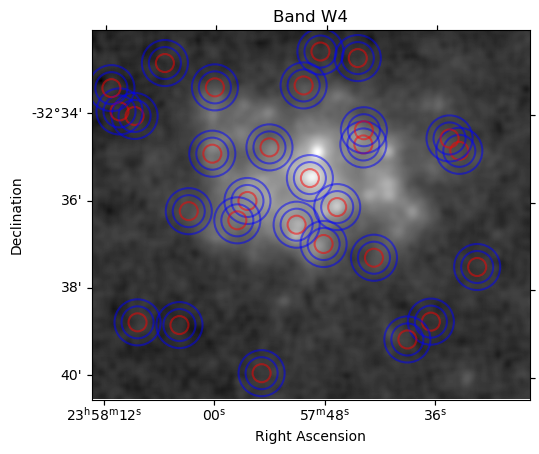

Band W3: 


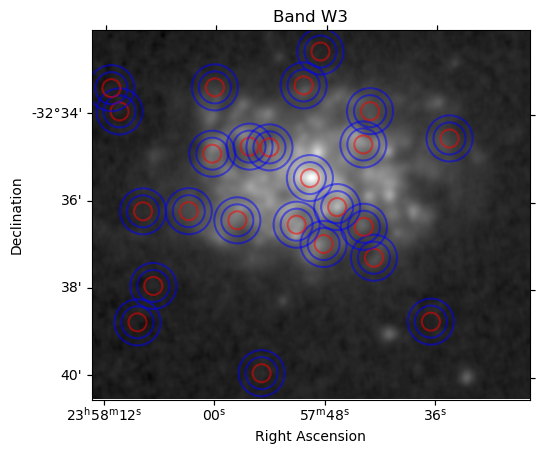

Band W2: 


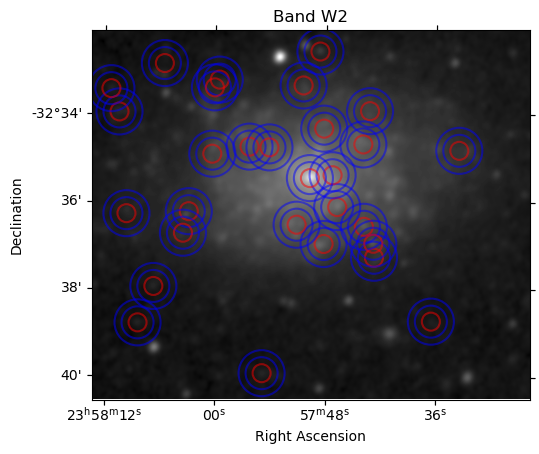

Band W1: 


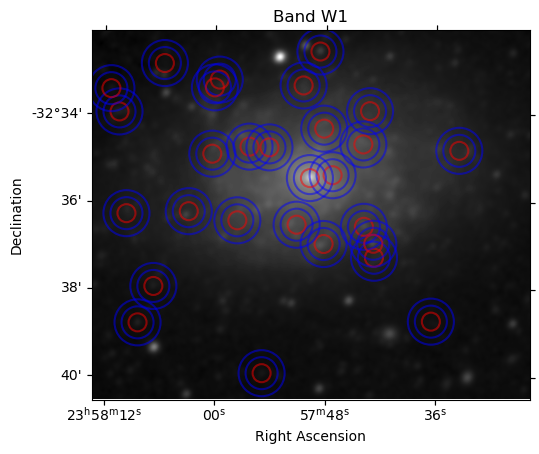

,band_id,Region,X,Y,Radius,Annulus_Inner_Radius,Annulus_Outer_Radius,Net Flux (Jy),Flag,aperture_sum,tot_bg,Target Counts,Target Flux,Annulus Counts,Annulus Flux,Image Data Shape,Mask Shape,Mask Type,Non-zero mask elements
1,{W4},2,384.187079,131.768686,9,16,23,0.000001,Valid,37801.670626,2.031762,37801.670626,2.031763,127405.552796,6.847790,"(369, 437)","(369, 437)",bool,255.0
2,{W4},3,366.350472,247.742249,9,16,23,0.000063,Valid,37854.108138,2.034519,37854.108138,2.034582,127578.439326,6.857083,"(369, 437)","(369, 437)",bool,240.0
3,{W4},4,356.612296,260.118440,9,16,23,0.000119,Valid,37853.208001,2.034415,37853.208001,2.034533,127571.892822,6.856731,"(369, 437)","(369, 437)",bool,241.0
4,{W4},5,337.953952,77.232043,9,16,23,0.000258,Valid,37792.988979,2.031039,37792.988979,2.031297,127360.193178,6.845352,"(369, 437)","(369, 437)",bool,251.0
5,{W4},6,281.147755,141.030790,9,16,23,0.000976,Valid,37870.171772,2.034469,37870.171772,2.035445,127575.285208,6.856913,"(369, 437)","(369, 437)",bool,219.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,{W1},98,45.106758,76.526072,9,16,23,0.000095,Valid,810.475004,0.001186,810.475004,0.001281,2529.289776,0.003997,"(369, 437)","(369, 437)",bool,254.0
472,{W1},101,280.450699,154.977536,9,16,23,0.000379,Valid,1992.647446,0.002770,1992.647446,0.003149,5907.220749,0.009335,"(369, 437)","(369, 437)",bool,225.0
476,{W1},105,210.918926,313.028816,9,16,23,0.000340,Valid,1642.659642,0.002255,1642.659642,0.002596,4810.175488,0.007601,"(369, 437)","(369, 437)",bool,250.0
478,{W1},107,203.923577,174.000270,9,16,23,0.000250,Valid,3422.723350,0.005158,3422.723350,0.005409,11002.177542,0.017386,"(369, 437)","(369, 437)",bool,250.0


,band_id,Region,X,Y,Radius,Annulus_Inner_Radius,Annulus_Outer_Radius,Net Flux (Jy),Flag,aperture_sum,tot_bg,Target Counts,Target Flux,Annulus Counts,Annulus Flux,Image Data Shape,Mask Shape,Mask Type,Non-zero mask elements
0,{W4},1,438.545629,85.376843,9,16,23,-0.223282,Low Flux,13481.764372,0.947899,13481.764372,0.724618,59439.853026,3.194772,"(369, 437)","(369, 437)",bool,92.0
1,{W4},2,384.187079,131.768686,9,16,23,0.000001,Valid,37801.670626,2.031762,37801.670626,2.031763,127405.552796,6.847790,"(369, 437)","(369, 437)",bool,255.0
2,{W4},3,366.350472,247.742249,9,16,23,0.000063,Valid,37854.108138,2.034519,37854.108138,2.034582,127578.439326,6.857083,"(369, 437)","(369, 437)",bool,240.0
3,{W4},4,356.612296,260.118440,9,16,23,0.000119,Valid,37853.208001,2.034415,37853.208001,2.034533,127571.892822,6.856731,"(369, 437)","(369, 437)",bool,241.0
4,{W4},5,337.953952,77.232043,9,16,23,0.000258,Valid,37792.988979,2.031039,37792.988979,2.031297,127360.193178,6.845352,"(369, 437)","(369, 437)",bool,251.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,{W1},120,176.811625,251.197414,9,16,23,0.000381,Valid,3447.341513,0.005067,3447.341513,0.005448,10807.048679,0.017077,"(369, 437)","(369, 437)",bool,255.0
492,{W1},121,314.489189,59.443072,9,16,23,-0.000209,Low Flux,809.786654,0.001489,809.786654,0.001280,3175.100965,0.005017,"(369, 437)","(369, 437)",bool,256.0
493,{W1},122,242.358645,-86.486904,9,16,23,NaN,Low Flux,NaN,NaN,NaN,NaN,NaN,NaN,"(369, 437)","(369, 437)",bool,0.0
494,NaN,123,132.209797,199.605292,9,16,23,NaN,Overlap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:

##running the for loop over every image and doing aperture photometry on each one
#currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1
rows = []
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)
        
        wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
        wcs = cutout.wcs
        cutout_data = cutout.data
        #print(cutout_data)
        positions = wcs.world_to_pixel_values(ra, dec)
        positions = np.array(list(zip(positions[0], positions[1])))

        #define the distance threshold for the KDTree grouping (in pixels)
        distance_threshold = 5

        #build the KDTree for efficient grouping
        tree = KDTree(positions)

        #query the KDTree to find points within the defined radius of dist threshold and group them together
        groups = tree.query_ball_tree(tree, r=distance_threshold)
       # print(groups)
        # consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
        unique_groups = []
        seen = set()
        for group in groups:
            group = tuple(sorted(group))
            if group not in seen:
                seen.add(group)
                unique_groups.append(group)
       # print(unique_groups)
        # for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
        #represents the consolidated postion of potentially multiple detections of one source.
        grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
        #print(grouped_positions)

        #define the Region(s) Of Interest (center x, center y, radius)
        ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
        

        # initialize valid rows plotting for the current image iteration
        valid_rows = []


        #now inputting the aperture photometry part
        # check for overlap and perform aperture photometry
        for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
            overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
            non_overlapping_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x,y), r)

            for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                if i != j: # ensures that a source is not compared to itself! wow
                    distance = dist((x, y) , (x2, y2)) 
                    if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                        overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                        if overlap_percent > .5:
                            overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                            break
                        else: 
                            overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                            # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                            # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.

                            #Handle overlaps that are acceptable (less than the threshold, but still overlapping by a small percent)
                            overlap_aperture = CircularAperture((x2, y2), r2)
                            overlap_photo_table = aperture_photometry(cutout_data, overlap_aperture)
                            overlap_counts = overlap_photo_table['aperture_sum'][0]
                            target_counts -= overlap_counts


            if overlap:
                #flag the sources that overlap
                rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                            'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
            else: #perform all the aperture photometry stuff
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                # also now apply the masked data
                masked_data = cutout_data * non_overlapping_mask
                target_photo_table = aperture_photometry(cutout_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
                target_counts = target_photo_table['aperture_sum'][0]

                if target_counts > 0: # 
                    # avoid taking the log of zero or negative value
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                         target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                else:
                        target_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.

                    
                    #calculate area of target aperutue
                target_area = target_aperture.area




                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
            
                if annulus_counts > 0:
                     # avoid taking the log of zero or negative value
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                         annulus_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                else:
                        annulus_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        
                #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
            
                #   Append the result as a dictionary to the list named 'rows'
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
            #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
               
                # Append valid results to valid_rows
                valid_rows.append({
                    'band_id': {band_labels[band_id]},
                    'Region': i+1, 'X': x, 'Y': y, 'Radius': r,
                    'Annulus_Inner_Radius': annulus_inner,
                    'Annulus_Outer_Radius': annulus_outer,
                    'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                })
                
            # Append valid_rows to rows (if needed for overall storage)
            #rows.extend(valid_rows)
        #print('valid rows', valid_rows)

    # Plotting for current image
    # Filter valid rows
        valid_rows_filtered = [row for row in valid_rows if row['Flag'] == 'Valid']
        fig, ax = plt.subplots(subplot_kw={'projection': wcs})
        norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
        for row in valid_rows_filtered:
            target_aperture = CircularAperture((row['X'], row['Y']), row['Radius'])
            annulus_aperture = CircularAnnulus((row['X'], row['Y']),
                                            row['Annulus_Inner_Radius'],
                                            row['Annulus_Outer_Radius'])
            target_aperture.plot(color='red', lw=1.5, alpha=.5, ax=ax)
            annulus_aperture.plot(color='blue', lw=1.5, alpha=.5, ax=ax)
        ax.imshow(cutout.data, cmap='gray', norm=norm)
        ax.set_xlabel('Right Ascension')
        ax.set_ylabel('Declination')
        plt.title(f'Band {band_labels[band_id]}')
        plt.show()
        

display_data = pd.DataFrame(rows)
display_data
pd.set_option("display.max_rows", 30)
display(display_data.loc[display_data['Flag']== 'Valid'])
display(display_data)




# Including source detection

In [ ]:



mean, median, std = sigma_clipped_stats(cutout_data, sigma=3.0)  
print((mean, median, std))

# subtract the background and find FWHM of sources at a certain threshold
#started at fwhm= 3 and threshold = 5
daofind = DAOStarFinder(fwhm=3.0, threshold=.7*std) # find the stars in the image that have FWHMs of around 3 pixels and have peaks approximately 5-sigma above the background. 
sources = daofind(cutout_data - median)  
print(type(sources))
# will likely run into iissues in the code below
for col in sources.colnames:  
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'  # for consistent table output
sources.pprint(max_width=3000)  

#likely the flux labeled in this is not converted!


# plot the image with marked locations of all the sources it detected.
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=8.0)

plt.imshow(image_data, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)


<SkyCoord (ICRS): (ra, dec) in deg
    (359.457, -32.592)>
('W4 Coadd 0000m334_ac51', 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-int-3.fits', '{"aws": {"bucket_name": "nasa-irsa-wise", "key":"wise/allwise/images/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-int-3.fits", "region": "us-west-2"}}', 2, 'image/fits', 0.0, -33.317778, array([4095, 4095], dtype=int32), array([2048., 2048.]), array([  0.      , -33.317778]), 'SIN', array([-0.00038194,  0.00038194]), array([-0.00038194, -0.        , -0.        ,  0.00038194]), 'W4', 2.209e-05, 2.336e-05, 1.984e-05, 'm', 13.0, 0.012, 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-unc-3.fits.gz', 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac51/0000m334_ac51-w4-cov-3.fits.gz', '0000m334_ac51')
('W1 Coadd 0000m334_ac51', 'https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0000/0000m334_ac

/var/folders/nd/77pj43rx7wbcbp0wx2qjq2140000gp/T/ipykernel_1295/2086743999.py:25: DtypeWarning: Columns (533,534) have mixed types. Specify dtype option on import or set low_memory=False.
  huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')


Band W4: 
Number of valid rows: 28
Processing row: {'band_id': {'W4'}, 'Region': 2, 'X': 384.18707876909957, 'Y': 131.76868566060102, 'Radius': 9, 'Annulus_Inner_Radius': 16, 'Annulus_Outer_Radius': 23, 'Net Flux (Jy)': 1.2411951741952976e-06, 'Flag': 'Valid', 'Exists?': '', 'Point Source Position': [], 'Point Sources': []}
Aperture forced at X: 384.18707876909957, Y: 131.76868566060102, Radius: 9
Detected position X: 202.77355236628748, Y: 163.58436213520173, Distance: 184.18225981738922
Detected position X: 205.49575661142504, Y: 173.64290240502086, Distance: 183.5321188305101
Detected position X: 231.52599630705566, Y: 187.28540944055607, Distance: 162.4423365928439
Detected position X: 318.8696159307455, Y: 186.52983240173472, Distance: 85.23587357470879
Detected position X: 243.53704601307987, Y: 191.97976117792112, Distance: 152.9960957973171
Detected position X: 277.02087099954787, Y: 203.24651210124244, Distance: 128.8164421197278
Detected position X: 295.2201910118641, Y: 204.

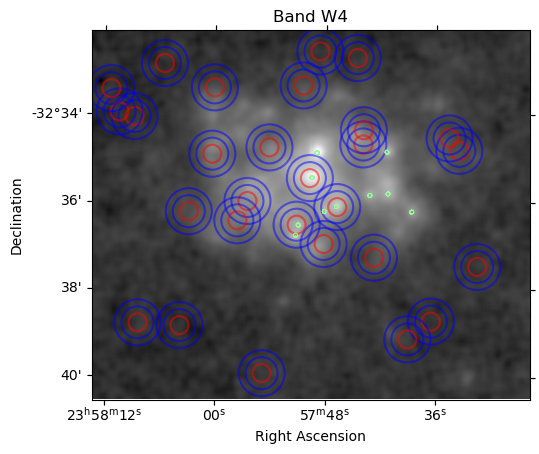

Band W3: 
Number of valid rows: 24
Processing row: {'band_id': {'W3'}, 'Region': 4, 'X': 356.61229617616186, 'Y': 260.11844049158367, 'Radius': 9, 'Annulus_Inner_Radius': 16, 'Annulus_Outer_Radius': 23, 'Net Flux (Jy)': 0.0008202270944556722, 'Flag': 'Valid', 'Exists?': '', 'Point Source Position': [], 'Point Sources': []}
Aperture forced at X: 356.61229617616186, Y: 260.11844049158367, Radius: 9
Detected position X: 373.43111236512186, Y: 21.005709598688814, Distance: 239.70350571707536
Detected position X: 295.93448846910576, Y: 64.32330351674128, Distance: 204.98178458373263
Detected position X: 190.2026687713419, Y: 97.48059109408094, Distance: 232.68698749533846
Detected position X: 224.6334880099391, Y: 153.14702062488718, Distance: 169.8861103012065
Detected position X: 166.6142567096567, Y: 158.76000513973767, Distance: 215.34341740134525
Detected position X: 127.50772481597768, Y: 161.29886083177536, Distance: 249.50794364563814
Detected position X: 202.73692145438702, Y: 163.

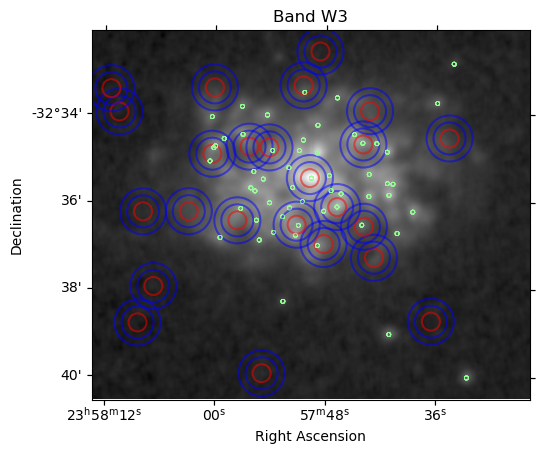

Band W2: 
Number of valid rows: 29
Processing row: {'band_id': {'W2'}, 'Region': 3, 'X': 366.3504722272364, 'Y': 247.7422492690373, 'Radius': 9, 'Annulus_Inner_Radius': 16, 'Annulus_Outer_Radius': 23, 'Net Flux (Jy)': 7.152675727006841e-05, 'Flag': 'Valid', 'Exists?': '', 'Point Source Position': [], 'Point Sources': []}
Aperture forced at X: 366.3504722272364, Y: 247.7422492690373, Radius: 9
Detected position X: 93.8648152532354, Y: 4.639456716835353, Distance: 365.16763411237844
Detected position X: 226.22752754135865, Y: 10.112484014747409, Distance: 275.8665346906915
Detected position X: 373.9850833485056, Y: 21.02955840905787, Distance: 226.84120323244983
Detected position X: 61.44063081858673, Y: 51.59244948317092, Distance: 362.5531069290172
Detected position X: 296.30796954502733, Y: 64.67343580857944, Distance: 196.0105676840083
Detected position X: 419.21699366425077, Y: 74.55119027980187, Distance: 181.08012591850914
Detected position X: 198.3403978539039, Y: 95.313350942159

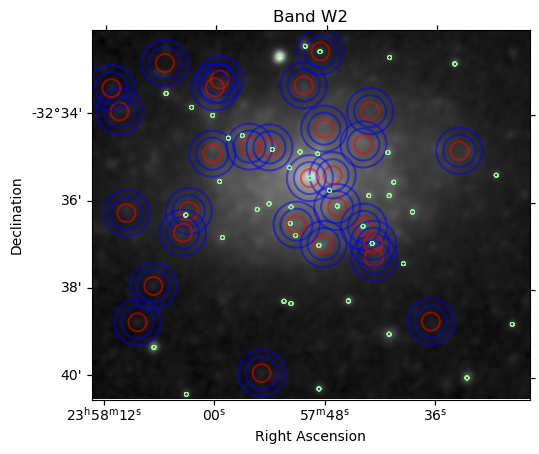

Band W1: 
Number of valid rows: 28
Processing row: {'band_id': {'W1'}, 'Region': 3, 'X': 366.3504722272364, 'Y': 247.7422492690373, 'Radius': 9, 'Annulus_Inner_Radius': 16, 'Annulus_Outer_Radius': 23, 'Net Flux (Jy)': 8.751015839810524e-05, 'Flag': 'Valid', 'Exists?': '', 'Point Source Position': [], 'Point Sources': []}
Aperture forced at X: 366.3504722272364, Y: 247.7422492690373, Radius: 9
Detected position X: 93.89411182672139, Y: 4.63503894659731, Distance: 365.1487149552281
Detected position X: 226.22025026391208, Y: 10.087783143930293, Distance: 275.8915083446756
Detected position X: 373.968180411722, Y: 21.03276031767327, Distance: 226.83743487037722
Detected position X: 61.526616223398406, Y: 51.60879704404533, Distance: 362.4719496329913
Detected position X: 296.36868144930673, Y: 64.7161839355887, Distance: 195.94895159691393
Detected position X: 419.3396582669185, Y: 74.61527784037246, Distance: 181.05469359618868
Detected position X: 198.31488798567057, Y: 95.5335006239016

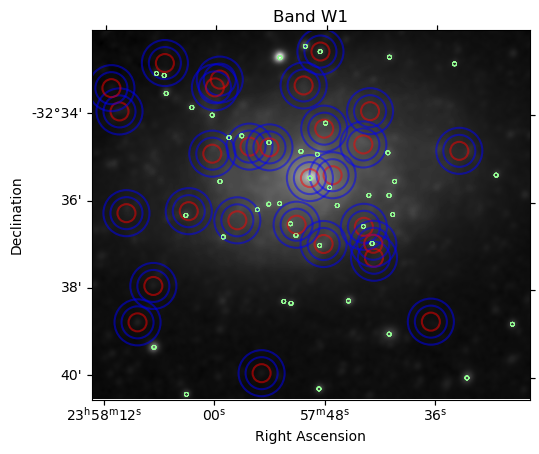

,band_id,Region,X,Y,Radius,Annulus_Inner_Radius,Annulus_Outer_Radius,Net Flux (Jy),Flag,aperture_sum,tot_bg,Target Counts,Target Flux,Annulus Counts,Annulus Flux,Image Data Shape,Mask Shape,Mask Type,Non-zero mask elements
1,{W4},2,384.187079,131.768686,9,16,23,0.000001,Valid,37801.670626,2.031762,37801.670626,2.031763,127405.552796,6.847790,"(369, 437)","(369, 437)",bool,255.0
2,{W4},3,366.350472,247.742249,9,16,23,0.000063,Valid,37854.108138,2.034519,37854.108138,2.034582,127578.439326,6.857083,"(369, 437)","(369, 437)",bool,240.0
3,{W4},4,356.612296,260.118440,9,16,23,0.000119,Valid,37853.208001,2.034415,37853.208001,2.034533,127571.892822,6.856731,"(369, 437)","(369, 437)",bool,241.0
4,{W4},5,337.953952,77.232043,9,16,23,0.000258,Valid,37792.988979,2.031039,37792.988979,2.031297,127360.193178,6.845352,"(369, 437)","(369, 437)",bool,251.0
5,{W4},6,281.147755,141.030790,9,16,23,0.000976,Valid,37870.171772,2.034469,37870.171772,2.035445,127575.285208,6.856913,"(369, 437)","(369, 437)",bool,219.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,{W1},98,45.106758,76.526072,9,16,23,0.000095,Valid,810.475004,0.001186,810.475004,0.001281,2529.289776,0.003997,"(369, 437)","(369, 437)",bool,254.0
472,{W1},101,280.450699,154.977536,9,16,23,0.000379,Valid,1992.647446,0.002770,1992.647446,0.003149,5907.220749,0.009335,"(369, 437)","(369, 437)",bool,225.0
476,{W1},105,210.918926,313.028816,9,16,23,0.000340,Valid,1642.659642,0.002255,1642.659642,0.002596,4810.175488,0.007601,"(369, 437)","(369, 437)",bool,250.0
478,{W1},107,203.923577,174.000270,9,16,23,0.000250,Valid,3422.723350,0.005158,3422.723350,0.005409,11002.177542,0.017386,"(369, 437)","(369, 437)",bool,250.0


,band_id,Region,X,Y,Radius,Annulus_Inner_Radius,Annulus_Outer_Radius,Net Flux (Jy),Flag,aperture_sum,tot_bg,Target Counts,Target Flux,Annulus Counts,Annulus Flux,Image Data Shape,Mask Shape,Mask Type,Non-zero mask elements
0,{W4},1,438.545629,85.376843,9,16,23,-0.223282,Low Flux,13481.764372,0.947899,13481.764372,0.724618,59439.853026,3.194772,"(369, 437)","(369, 437)",bool,92.0
1,{W4},2,384.187079,131.768686,9,16,23,0.000001,Valid,37801.670626,2.031762,37801.670626,2.031763,127405.552796,6.847790,"(369, 437)","(369, 437)",bool,255.0
2,{W4},3,366.350472,247.742249,9,16,23,0.000063,Valid,37854.108138,2.034519,37854.108138,2.034582,127578.439326,6.857083,"(369, 437)","(369, 437)",bool,240.0
3,{W4},4,356.612296,260.118440,9,16,23,0.000119,Valid,37853.208001,2.034415,37853.208001,2.034533,127571.892822,6.856731,"(369, 437)","(369, 437)",bool,241.0
4,{W4},5,337.953952,77.232043,9,16,23,0.000258,Valid,37792.988979,2.031039,37792.988979,2.031297,127360.193178,6.845352,"(369, 437)","(369, 437)",bool,251.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,{W1},120,176.811625,251.197414,9,16,23,0.000381,Valid,3447.341513,0.005067,3447.341513,0.005448,10807.048679,0.017077,"(369, 437)","(369, 437)",bool,255.0
492,{W1},121,314.489189,59.443072,9,16,23,-0.000209,Low Flux,809.786654,0.001489,809.786654,0.001280,3175.100965,0.005017,"(369, 437)","(369, 437)",bool,256.0
493,{W1},122,242.358645,-86.486904,9,16,23,NaN,Low Flux,NaN,NaN,NaN,NaN,NaN,NaN,"(369, 437)","(369, 437)",bool,0.0
494,NaN,123,132.209797,199.605292,9,16,23,NaN,Overlap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
####Defining the constants

#define coordinates	
ra= 359.45700000000016
dec= -32.592000000000013
pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#im_table
im_table.to_table().colnames
for i in range(len(im_table)):
    print(im_table[i])


   #grab the x-ray sources for this galaxy
#import huge csv and grab the name and ra and dec needed for each source.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec', 'Gname_Modified','Gname_Homogenized']
g_huge = huge[columns]
g_huge[0:100]

#locate through merging
df1 = targetgals
df2 = g_huge

merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns = ['RA','Dec','Gname_Homogenized']
Xray_sources = merged_data[columns]
Xray_sources

# just want NGC 7793s sources
sources_7793 = Xray_sources.loc[Xray_sources['Gname_Homogenized'] == 'NGC 7793']
#sources_7793
#define the X-ray sources of NGC 7793
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask

# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6,'w4':12.98 }

##running the for loop over every image and doing aperture photometry on each one
#currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1
rows = []
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase
    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)
        
        wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
        wcs = cutout.wcs
        cutout_data = cutout.data
        #print(cutout_data)
        positions = wcs.world_to_pixel_values(ra, dec)
        positions = np.array(list(zip(positions[0], positions[1])))

        #define the distance threshold for the KDTree grouping (in pixels)
        distance_threshold = 5

        #build the KDTree for efficient grouping
        tree = KDTree(positions)

        #query the KDTree to find points within the defined radius of dist threshold and group them together
        groups = tree.query_ball_tree(tree, r=distance_threshold)
       # print(groups)
        # consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
        unique_groups = []
        seen = set()
        for group in groups:
            group = tuple(sorted(group))
            if group not in seen:
                seen.add(group)
                unique_groups.append(group)
       # print(unique_groups)
        # for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
        #represents the consolidated postion of potentially multiple detections of one source.
        grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
        #print(grouped_positions)

        #define the Region(s) Of Interest (center x, center y, radius)
        ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
        

        # initialize valid rows plotting for the current image iteration
        valid_rows = []


        #now inputting the aperture photometry part
        # check for overlap and perform aperture photometry
        for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
            overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
            non_overlapping_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x,y), r)

            for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                if i != j: # ensures that a source is not compared to itself! wow
                    distance = dist((x, y) , (x2, y2)) 
                    if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                        overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                        if overlap_percent > .5:
                            overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                            break
                        else: 
                            overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                            # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                            # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.

                            #Handle overlaps that are acceptable (less than the threshold, but still overlapping by a small percent)
                            overlap_aperture = CircularAperture((x2, y2), r2)
                            overlap_photo_table = aperture_photometry(cutout_data, overlap_aperture)
                            overlap_counts = overlap_photo_table['aperture_sum'][0]
                            target_counts -= overlap_counts


            if overlap:
                #flag the sources that overlap
                rows.append({ 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                            'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': np.nan, 'Flag': 'Overlap' }) 
            else: #perform all the aperture photometry stuff
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                # also now apply the masked data
                masked_data = cutout_data * non_overlapping_mask
                target_photo_table = aperture_photometry(cutout_data, target_aperture) #replace image_data with "masked_data" to incorporate the code for overlapping
                target_counts = target_photo_table['aperture_sum'][0]

                if target_counts > 0: # 
                    # avoid taking the log of zero or negative value
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                         target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                else:
                        target_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.

                    
                    #calculate area of target aperutue
                target_area = target_aperture.area




                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
            
                if annulus_counts > 0:
                     # avoid taking the log of zero or negative value
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                         annulus_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                else:
                        annulus_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        
                #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
            
                #   Append the result as a dictionary to the list named 'rows'
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask)})  #will prolly have to change the name of the Flux here!!!
            #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
               
                # Append valid results to valid_rows
                valid_rows.append({
                    'band_id': {band_labels[band_id]},
                    'Region': i+1, 'X': x, 'Y': y, 'Radius': r,
                    'Annulus_Inner_Radius': annulus_inner,
                    'Annulus_Outer_Radius': annulus_outer,
                    'Net Flux (Jy)': net_flx, 'Flag':'Valid' if net_flx > 0 else 'Low Flux', 'Exists?': '', 'Point Source Position' : []
                })
                
        #Source detection code
        mean, median, std = sigma_clipped_stats(cutout_data, sigma=3.0)  
       #print((mean, median, std))

        # subtract the background and find FWHM of sources at a certain threshold
        #started at fwhm= 3 and threshold = 5
        daofind = DAOStarFinder(fwhm=3.0, threshold=.55*std) # find the stars in the image that have FWHMs of around 3 pixels and have peaks approximately 5-sigma above the background. 
        sources = daofind(cutout_data - median)  
        #print(type(sources))
        # will likely run into iissues in the code below
        for col in sources.colnames:  
            if col not in ('id', 'npix'):
                sources[col].info.format = '%.2f'  # for consistent table output
       # sources.pprint(max_width=3000)  

        #likely the flux labeled in this is not converted!
        
        # plot the image with marked locations of all the sources it detected.
        detected_positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
        apertures = CircularAperture(detected_positions, r=2)


        # Plotting for current image
        # Filter valid rows
        valid_rows_filtered = [row for row in valid_rows if row['Flag'] == 'Valid']
        print(f"Number of valid rows: {len(valid_rows_filtered)}")
        if len(valid_rows_filtered) == 0:
            print("No valid rows to process.")
        # Initialize Point Sources
        for row in valid_rows_filtered:
            row['Point Sources'] = []
        # Was there a point source there?

        for row in valid_rows_filtered:
            print(f"Processing row: {row}")
            apertures_forced = CircularAperture((row['X'], row['Y']), r=row['Radius'])
            print(f"Aperture forced at X: {row['X']}, Y: {row['Y']}, Radius: {row['Radius']}")
    
            for detected_position in detected_positions:
                detected_x, detected_y = detected_position
                distance = dist((row['X'], row['Y']), (detected_x, detected_y) )
                print(f"Detected position X: {detected_x}, Y: {detected_y}, Distance: {distance}")
        
                if distance <= row['Radius']:
                    row['Exists?'] = 'Point Source Detected'
                    row['Point Source Position'].append((detected_x, detected_y))

        print('valid sources', valid_rows_filtered)
        #valid_rows_filteredagain = [row for row in valid_rows_filtered if row['Exists?'] == 'Point Source Detected'] #This doesnt work the way you think it does, it only plots things that have sources in the apertures unfortunately







         # Plotting for current image
        fig, ax = plt.subplots(subplot_kw={'projection': wcs})
        norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
        for row in valid_rows_filtered:
            target_aperture = CircularAperture((row['X'], row['Y']), row['Radius'])
            annulus_aperture = CircularAnnulus((row['X'], row['Y']), row['Annulus_Inner_Radius'], row['Annulus_Outer_Radius'])
            target_aperture.plot(color='red', lw=1.5, alpha=.5, ax=ax)
            annulus_aperture.plot(color='blue', lw=1.5, alpha=.5, ax=ax)
            
            apertures.plot(color='#98ff98', lw=.5, alpha=0.5) #  #FF69B4 for hot pink
        ax.imshow(cutout.data, cmap='gray', norm=norm, interpolation='nearest')
        ax.set_xlabel('Right Ascension')
        ax.set_ylabel('Declination')
        plt.title(f'Band {band_labels[band_id]}')
        plt.show()






















        

display_data = pd.DataFrame(rows)
display_data
pd.set_option("display.max_rows", 30)
display(display_data.loc[display_data['Flag']== 'Valid'])
display(display_data)


